In [12]:
# 인공 신경망 구현에 사용할 라이브러리 임포트
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

In [13]:
# numpy 임의성 조절
np.random.seed(42)

In [14]:
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle5 as pickle
import os
import numpy as np


save_file = "C:\\Users\\lg\\Downloads\\deep-learning-from-scratch-master\\common\\dataset\\mnist.pkl"


def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNIST 데이터셋 읽기
    
    Parameters
    ----------
    normalize : 이미지의 픽셀 값을 0.0~1.0 사이의 값으로 정규화할지 정한다.
    one_hot_label : 
        one_hot_label이 True면、레이블을 원-핫(one-hot) 배열로 돌려준다.
        one-hot 배열은 예를 들어 [0,0,1,0,0,0,0,0,0,0]처럼 한 원소만 1인 배열이다.
    flatten : 입력 이미지를 1차원 배열로 만들지를 정한다. 
    
    Returns
    -------
    (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
    """
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])    
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


In [15]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [16]:
def sigmoid(x):
    """시그모이드 함수"""
    return 1/(1 + np.exp(-x))

In [17]:
def d_sigmoid(x):
    """시그모이드 미분 함수"""
    return (np.exp(-x))/((np.exp(-x)+1)**2)

In [18]:
def initialize_parameters(nodes_per_layer):
    """신경망의 가중치와 편향을 초기화해주는 함수"""
    L = len(nodes_per_layer) - 1  # 층 개수 저장
    parameters = {}
    
    # 1층 부터 L 층까지 돌면서 가중치와 편향 초기화
    for l in range(1, L+1):
        parameters['W' + str(l)] = np.random.randn(nodes_per_layer[l], nodes_per_layer[l-1]) * np.sqrt(1. / nodes_per_layer[l])
        parameters['b' + str(l)] = np.random.randn(nodes_per_layer[l]) * np.sqrt(1. / nodes_per_layer[l])   
    return parameters

In [19]:
def feed_forward(x, parameters):
    """순전파 함수"""
    cache = {'a0': x}  # 0 번째 층 출력 저장
    L = len(parameters) // 2  # 층 수 저장
    
    for l in range(1, L+1):
        # 전 층 뉴런의 출력, 현재 층 뉴런들의 가중치, 편향 데이터를 가지고 온다. (코드를 쓰세요)
        a_prev = cache['a'+str(l-1)]
        W = parameters['W'+str(l)]
        b = parameters['b'+str(l)]
        
        # 가지고 온 데이터로 z와 a를 계산한다. (코드를 쓰세요)
        z = W@a_prev + b
        a = sigmoid(z)

        # 결과 값을 캐시에 저장한다.
        cache['z' + str(l)] = z
        cache['a' + str(l)] = a           
    return a, cache

In [20]:
def compute_accuracy(x_val, y_val, parameters):
    #print(parameters)
    """테스트 데이터에서 예측값들의 성능을 계산하는 함수"""
    predictions = []

    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(y))
    return np.mean(predictions)

In [21]:
def compute_loss(x_val, y_val, parameters):
    """학습 데이터에서 현재 모델의 손실을 계산하는 함수"""
    loss = 0
    
    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        loss += np.mean((output - y)**2) / 2
        
    return loss / len(x_val)

In [22]:
def back_prop(prediction, y, cache, parameters):
    """역전파 함수"""
    gradients = {}
    L = len(cache) // 2
    da = (prediction - y) / y.shape[0]
    
    for layer in range(L, 0, -1):
        # 역전파 행렬 연산을 사용해서 각 요소에 대한 편미분 계산
        # 코드를 쓰세요
        db=d_sigmoid(cache['z'+str(layer)]) * da
        dW=np.outer(db, cache['a'+str(layer-1)])
        da = parameters['W' + str(layer)].T @ db
        
        
        # 계산한 편미분 값들을 저장
        gradients['dW' + str(layer)] = dW
        gradients['db' + str(layer)] = db
    
    # 계산한 편미분 값들 리턴
    return gradients

In [23]:
def update(parameters, gradients, alpha, m):
    """계산한 경사로 가중치와 편향을 업데이트 하는 함수"""
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] -= alpha * gradients['dW'+str(layer)] / m
        parameters['b'+str(layer)] -= alpha * gradients['db'+str(layer)] / m
    
    return parameters

In [24]:
def train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, epoch, alpha):
    """신경망을 학습시키는 함수"""
    parameters = initialize_parameters(neurons_per_layer)
    loss_list = []
    m = X_train.shape[0]
    
    # epoch 번 경사 하강을 한다
    for i in range(epoch):
        parameters_copy = parameters.copy()
        
        # 모든 이미지에 대해서 경사 계산 후 평균 계산
        for x, y in zip(X_train, Y_train):
            prediction, cache = feed_forward(x, parameters)
            gradients = back_prop(prediction, y, cache, parameters)
            parameters_copy = update(parameters_copy, gradients, alpha, m)
        
        # 가중치와 편향 실제로 업데이트
        parameters = parameters_copy
        loss_list.append(compute_loss(X_train, Y_train, parameters))
        print('{}번째 경사 하강, 테스트 셋에서 성능: {}'.format(i+1, round(compute_accuracy(X_test, Y_test, parameters), 2)))     
            
    return loss_list, parameters

In [26]:
# 실행 코드
neurons_per_layer = [784, 128, 64, 10]
parameters = initialize_parameters(neurons_per_layer)

loss_list, parameters = train_nn(x_train, t_train, x_test, t_test, neurons_per_layer, 100, 300)

1번째 경사 하강, 테스트 셋에서 성능: 0.36
2번째 경사 하강, 테스트 셋에서 성능: 0.43
3번째 경사 하강, 테스트 셋에서 성능: 0.57
4번째 경사 하강, 테스트 셋에서 성능: 0.67
5번째 경사 하강, 테스트 셋에서 성능: 0.73
6번째 경사 하강, 테스트 셋에서 성능: 0.77
7번째 경사 하강, 테스트 셋에서 성능: 0.8
8번째 경사 하강, 테스트 셋에서 성능: 0.82
9번째 경사 하강, 테스트 셋에서 성능: 0.84
10번째 경사 하강, 테스트 셋에서 성능: 0.85
11번째 경사 하강, 테스트 셋에서 성능: 0.86
12번째 경사 하강, 테스트 셋에서 성능: 0.87
13번째 경사 하강, 테스트 셋에서 성능: 0.87
14번째 경사 하강, 테스트 셋에서 성능: 0.88
15번째 경사 하강, 테스트 셋에서 성능: 0.88
16번째 경사 하강, 테스트 셋에서 성능: 0.89
17번째 경사 하강, 테스트 셋에서 성능: 0.89
18번째 경사 하강, 테스트 셋에서 성능: 0.89
19번째 경사 하강, 테스트 셋에서 성능: 0.89
20번째 경사 하강, 테스트 셋에서 성능: 0.89
21번째 경사 하강, 테스트 셋에서 성능: 0.9
22번째 경사 하강, 테스트 셋에서 성능: 0.9
23번째 경사 하강, 테스트 셋에서 성능: 0.9
24번째 경사 하강, 테스트 셋에서 성능: 0.9
25번째 경사 하강, 테스트 셋에서 성능: 0.9
26번째 경사 하강, 테스트 셋에서 성능: 0.9
27번째 경사 하강, 테스트 셋에서 성능: 0.9
28번째 경사 하강, 테스트 셋에서 성능: 0.9
29번째 경사 하강, 테스트 셋에서 성능: 0.91
30번째 경사 하강, 테스트 셋에서 성능: 0.91
31번째 경사 하강, 테스트 셋에서 성능: 0.91
32번째 경사 하강, 테스트 셋에서 성능: 0.91
33번째 경사 하강, 테스트 셋에서 성능: 0.91
34번째 경사 하강, 테스트 셋에서 성능: 0.91
35번째 경사 하강, 테스트 셋에서 성능: 0.91
36번

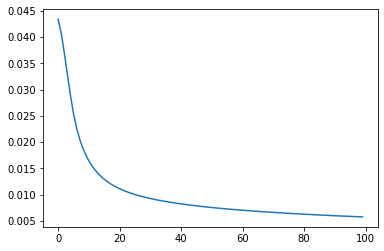

In [27]:
plt.plot(loss_list)
plt.show()